<center><font size=5><b>Gepard + PyTorch tutorial</b></font></center>
<center> Kresimir Kumericki, Lanzhou, June 2023</center>

This will **not** yet work with official stable Gepard Python package. You need to clone the Gepard github repository, switch to the new `torch` branch
```
git checkout torch
```
and follow the instructions for "Installation from sources" at Gepard web page:
https://gepard.phy.hr/docs/install.html#installation-from-sources .
(It's best to install Gepard in a way that makes it editable, as explained on that page.)  Obviously, besides all the standard Gepard dependencies, you need pytorch Python package.

**Note 1:** This new `torch` branch of Gepard works only with Neural models. Standard models like `KM` will **not** work presently. (In the future both kind of models should be usable at the same time.) If you need both neural and non-neural Gepard models, you either have to use Python's virtualenv, or switch git branches from `torch` to `master/devel`.

**Note 2:** In the official Gepard, you can evaluate observables like $A_{LU}$ and CFFs in two equivalent ways, either directly, like `th.ALU(pt)` or `th.ImH(pt)`, or, indirectly, using the `predict` method:  `th.predict(pt, observable='ALU')` or `th.predict(pt, observable='ImH')`  where keyword argument `observable` is not necessary if DataPoint instance `pt` has a correct value of attribute `pt.observable`.  In the `torch` Gepard branch, only `predict` is reliable. You should **not** use direct approach unless you are sure you know what you are doing. (This will also likely be fixed sometimes in the future.).

# Init

The `autoreload` in the following cell enables the very convenient "live" updates: You can edit the Gepard code and it is immediately active, without restarting the Jupyter kernel. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import gepard as g

In [3]:
import gepard.plots as gplots  # some prepared plots

In [4]:
from gepard.fits import GLO15new, AUTIpts, ALUIpts   # Selection of old JLab and HERMES datasets

In [5]:
import torch
import matplotlib.pyplot as plt

# Simplest example

For the purpose of example use a small subset of beam charge asymmetry and beam spin asymmetry DVCS data:

In [6]:
fitpoints = g.dset[31] + g.dset[8]

In [7]:
g.describe_data(fitpoints)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
12 x AC      HERMES  0.0    31  arXiv:0802.2499
12 x AC      HERMES  1.0    31  arXiv:0802.2499
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
----------------------------------------------
TOTAL = 36


It will be automatic at some point, but now  user himself must give a unique `ptid` attribute to each data point.
(This is used by the loss function to match inputs sent to neural nets with other properties of datapoint (like polarization,
energy etc.) needed to calculate the observable.)

In [8]:
for k, pt in enumerate(fitpoints):
        pt.ptid = k

We now create a complete theory class like explained in [Gepard documentation](https://gepard.phy.hr/docs/tutorial.html).
The new possibility is to override default neural net architecture and optimizer by overriding the `build_net` method like this:

In [9]:
class NNTest(g.model.NeuralModel, g.eff.DipoleEFF, g.dvcs.BMK):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = torch.nn.Sequential(
                torch.nn.Linear(2, 12),
                torch.nn.ReLU(),
                torch.nn.Linear(12, 17),
                torch.nn.ReLU(),
                torch.nn.Linear(17, 12),
                torch.nn.ReLU(),
                torch.nn.Linear(12, len(self.output_layer))
            )
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05)
        return nn_model, optimizer

Here we changed two things from the default: 1. we decreased the number of neurons in hidden layers, and 2. we increased the learning rate from the default 0.01.
**Note:** The network input has to be two-dimensional, and it represents (xB, t) kinematics. It would not be difficult to extend this to (xB, t, Q2), like PARTONS and Virginia people do, but I think this is not needed at the moment. Also, output has to be equal to length of the `output_layer` list which will be specified during instatiation of the theory object.

We now create theory object instance, and can specify CFFs that will be represented by the neural net:

In [10]:
th = NNTest(output_layer=['ImH', 'ReH'])

Now we create instance of the `NeuralFitter` object, where in addition to obligatory arguments (list of datapoints and theory object),
we can control details of the fitting process:

In [11]:
f = g.fitter.NeuralFitter(fitpoints, th, nnets=3, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)

| argument | meaning                                                                                                           |
|----------|-------------------------------------------------------------------------------------------------------------------|
| nnets    | How many trained nets we want                                                                                     |
| maxtries | How many training procedure we do before we give up.                                                              |
| nbatch   | Number of batches in each training.                                                                               |
| batchlen | Lenght of each batch. After this validation loss is calculated.                                                   |
| minprob  | Minimal acceptable probability of the data for net's chi-square/npt. If net is worse than that it is thrown away. |ay. |

We now train the required number of nets. 
During training of each net, fitpoints are randomly separared into training set (70%) and validation set (30%), and after (nbatch x batchlen) epochs the net with best validation loss
is kept, and if chisquare for total dataset is acceptable (controlled by `minprob`), net is added to the `th.nets` and later is used for predictions.

In [12]:
%%time
f.fitgood()

Epoch 10: train error = 2.68 test error = 3.49
Epoch 20: train error = 2.15 test error = 4.37
Epoch 30: train error = 1.71 test error = 3.89
Epoch 40: train error = 1.04 test error = 3.33
Epoch 50: train error = 0.96 test error = 3.45
Epoch 60: train error = 0.83 test error = 4.07
[1/100] Net 0 --> test_err = 3.326931210211224, P(chisq=53.43898975957861)=0.030752778764669197
Epoch 10: train error = 2.96 test error = 6.84
Epoch 20: train error = 1.77 test error = 6.96
Epoch 30: train error = 1.69 test error = 5.89
Epoch 40: train error = 1.49 test error = 3.13
Epoch 50: train error = 1.47 test error = 3.14
Epoch 60: train error = 1.46 test error = 3.17
[2/100] Net 1 --> test_err = 3.1340311471286713, P(chisq=39.60082202773712)=0.3124128319679351
Epoch 10: train error = 2.65 test error = 5.38
Epoch 20: train error = 2.30 test error = 3.69
Epoch 30: train error = 2.01 test error = 2.88
Epoch 40: train error = 1.47 test error = 1.98
Epoch 50: train error = 1.26 test error = 1.88
Epoch 60: 

Training loss over epochs for the last net:

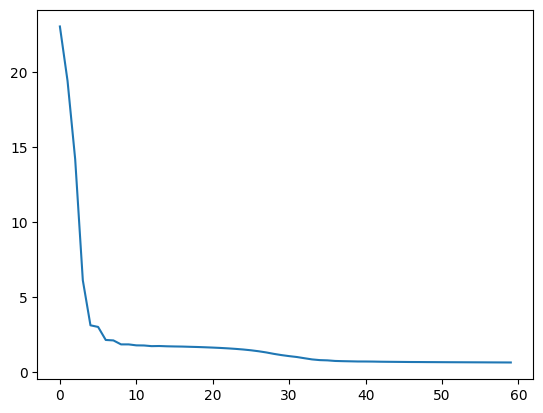

In [13]:
plt.plot(f.history)
plt.show()

Now theory has three trained nets, and future predictions are calculated by evaluating all nets and taking the mean value of results:

In [14]:
th.predict(fitpoints[0], uncertainty=True)  # mean value and standard deviation

(-0.003946239107233286, 0.000415593761765004)

You can also get individual predictions by all nets:

In [15]:
th.predict(fitpoints[0], mesh=True)

array([-0.0038352 , -0.00350193, -0.00450159])

Plotting the mean value and error band for total dataset:

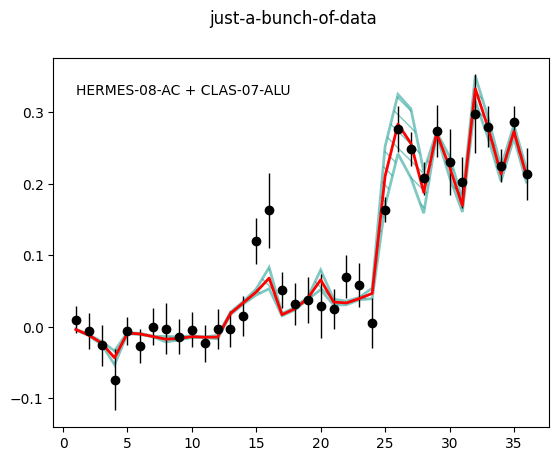

In [16]:
fig = gplots.jbod(points=fitpoints, lines=[th], bands=[th])

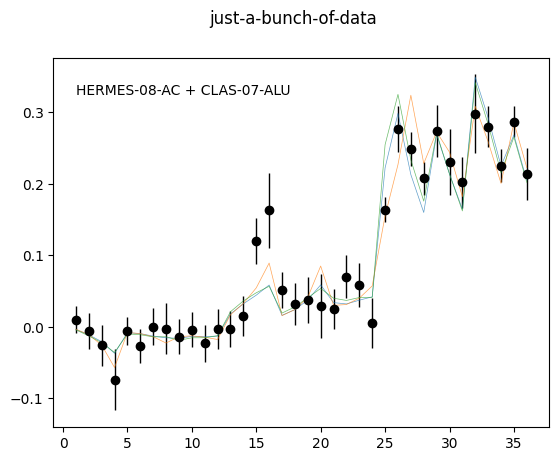

In [17]:
fig = gplots.jbod(points=fitpoints, mesh=th)   # Plot the mesh of individual nets

# Saving and loading the trained models

You should save only the list of trained nets by using the torch saving routine:

In [18]:
torch.save(th.nets, 'test.tar')

You also need to remember what is your output layer representing.
Than you can recreate the `theory` instance like this:

In [19]:
class NNTest(g.model.NeuralModel, g.eff.DipoleEFF, g.dvcs.BMK):
    pass

th_restored = NNTest(output_layer=['ImH', 'ReH'])

th_restored.nets = torch.load('test.tar')

for net in th_restored.nets:
    net.eval()

Note that you don't need to specify `build_net` architecture because this is saved with trained nets.
This model now works normally:

In [20]:
th_restored.predict(fitpoints[0], uncertainty=True)  # mean value and standard deviation

(-0.003946239107233286, 0.000415593761765004)

# Impact of EicC simulated data

More involved example now. We train two models, with 8 networks each, first with only
HERMES and JLab data, and second model with also mock EicC transversal target asymmetry
data. This dataset is not part of the Gepard distribution so I send it with this notebook.
It has Gepard data ID=3004. Filename is `AUTI-EicC-v0-NN20.dat` and it has to be put in
the directory `gepard/src/gepard/datasets/ep2epgamma` .

Training takes a long time, so I did it outside of notebook, using Python script like this one:

```
#!/usr/bin/env python
# coding: utf-8

import torch

import gepard as g
from gepard.fits import GLO15new, AUTIpts, ALUIpts   # some old datapoints

pts = GLO15new + g.dset[136]
# We reduce dataset for faster training:
fitpoints = pts[::3] + AUTIpts + ALUIpts + g.dset[3004]

# Need unique id's - this will be automatic in Gepard soon
for k, pt in enumerate(fitpoints):
        pt.ptid = k

class NNTest(g.model.NeuralModel, g.eff.DipoleEFF, g.dvcs.BM10tw2):
    pass

th = NNTest(output_layer=['ReH', 'ImH', 'ReE', 'ImE', 'ImHt', 'ReHt'])

f = g.fitter.NeuralFitter(fitpoints, th, nnets=10, nbatch=30, minprob=1.e-6)

f.fitgood(minchi=300)  # minchi is minimal chi-square, somewhat analogous to minprob
```

Note that instead of `BMK` formulas I use `BM10tw2` which are more advanced formulas.
(Old `BMK` don't have transversal target asymmetry implemented.)
Training took about 1 hour on my laptop. I created `old` nets by removing EicC dataset 3004,
and `new` dataset by keeping it.  Both sets of nets are saved and I send it with this notebook.
I restore now these saved nets:

In [1]:
thold = NNTest(output_layer=['ReH', 'ImH', 'ReE', 'ImE', 'ImHt', 'ReHt'])
thnew = NNTest(output_layer=['ReH', 'ImH', 'ReE', 'ImE', 'ImHt', 'ReHt'])

NameError: name 'NNTest' is not defined

In [23]:
thold.name = 'JLab+HERMES'
thnew.name = 'JLab+HERMES+EicC'

In [24]:
# only 8 nets are saved from 10, I removed two worst nets by hand
thold.nets = torch.load('old.tar')
thnew.nets = torch.load('new.tar')

In [25]:
for net in thold.nets:
    net.eval()

for net in thnew.nets:
    net.eval()

Check how these two models describe EicC data:

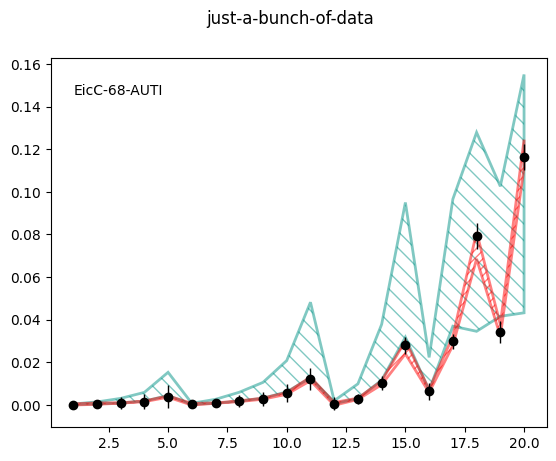

In [26]:
fig = gplots.jbod(points=g.dset[3004][:20], bands=[thold, thnew])

Finally, impact on CFFs:

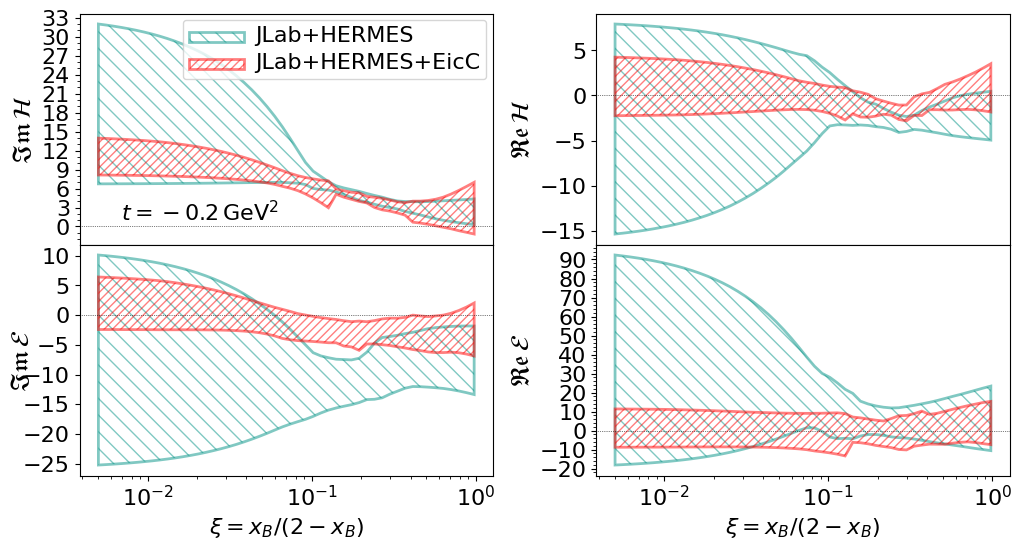

In [27]:
fig = gplots.CFF3log(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  bands=[thold, thnew], tval=-0.2)

This figure is roughly similar to the one in EicC white paper arXiv:2102.09222, Fig. 2.12. It is not exacly the same because for Fig 2.12 more nets have been
trained and more care was exercised in prunig the nets with anomalous behaviour or too large chi-square.  Also, procedure is inherently statistical so
you will never get exactly the same plot.

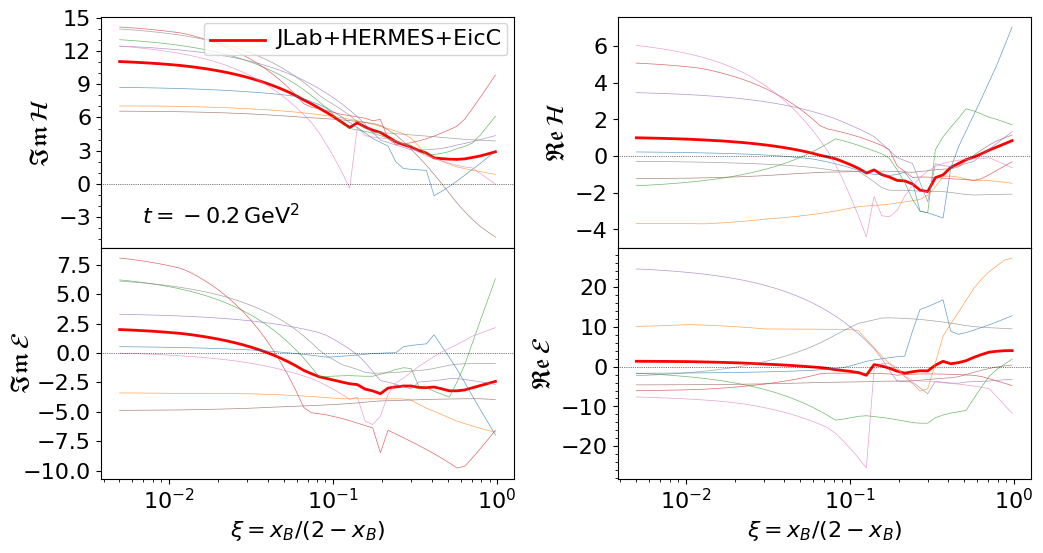

In [28]:
fig = gplots.CFF3log(cffs=['ImH', 'ReH', 'ImE', 'ReE'], lines=[thnew], mesh=thnew, tval=-0.2)